### Unweighted

In [2]:
import os

# Define the directory path
directory = r'F:\GitHub\KU-1\Variations\New Data\Measurements'

# Create an empty list to store the file paths
file_paths = []

# Loop through all the files in the directory and its subdirectories
for root, dirs, files in os.walk(directory):
    for file in files:
        # Check if the file is a .csv file
        if file.endswith('.csv'):
            # If it is, append its path (relative to the directory) to the csv_files list
            file_paths.append(os.path.join(root[len(directory)+1:], file))

# Add the directory path to each file path in the list
file_paths = [os.path.join('New Data', 'Measurements', file).replace('\\', '/') for file in file_paths]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

def calculate_average(file_paths, output_path):

    # Function to read and interpolate a .csv file
    def read_and_interpolate(file_path, x_values):
        df = pd.read_csv(file_path)
        
        # Group data points by the same X-value and take the mean of their Y-values
        df = df.groupby('X', as_index=False).mean()
        
        min_x = df['X'].min()
        max_x = df['X'].max()
        x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
        f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
        y_values = np.empty_like(x_values)
        y_values[:] = np.nan
        y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
        return y_values

    # X values to interpolate to (logarithmically spaced from 20 Hz to 20 kHz)
    x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

    # Read and interpolate all .csv files
    data = [read_and_interpolate(file_path, x_values) for file_path in file_paths]

    def find_mean_in_range(data, x_min, x_max):
        indices = (x_values >= x_min) & (x_values <= x_max)
        return np.mean(data[indices])

    alignment_freq_range = (200, 10000)  # frequency range for alignment

    # Calculate the mean values of each dataset in the alignment frequency range
    mean_values = [find_mean_in_range(data[i], *alignment_freq_range) for i in range(len(data))]

    # Calculate the target mean value as the average of the individual mean values
    target_mean = np.mean(mean_values)

    # Align datasets to the target mean value
    for i in range(len(data)):
        shift = target_mean - mean_values[i]
        data[i] += shift

    # Compute the final average of the aligned datasets
    average = np.mean(data, axis=0)

    # Save the average to a .csv file
    average_df = pd.DataFrame({'X': x_values, 'Y': average})
    average_df = average_df.dropna(subset=['Y'])  # Remove rows where Y is NaN
    average_df.to_csv(output_path, index=False)
    
    return x_values, average, data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

# Function to read and interpolate a .csv file
def interpolate_and_restore_nans(y_values, window):
    not_nan = ~np.isnan(y_values)
    indices = np.arange(len(y_values))
    interpolated_y_values = np.interp(indices, indices[not_nan], y_values[not_nan])
    filtered_y_values = savgol_filter(interpolated_y_values, window, 3)
    filtered_y_values[~not_nan] = np.nan
    return filtered_y_values

def plot_data(x_values, average, data, title, color):
    
    plt.figure(figsize=(20, 10))
    for y_values in data:
        smoothed_y_values = interpolate_and_restore_nans(y_values, 51)  # Apply Savitzky-Golay filter
        plt.plot(x_values, smoothed_y_values, color='lightgray', linewidth=0.75)
    plt.ylim(30, 85)
    plt.xlim(20, 20000)
    plt.plot(x_values, average, color=color, linewidth=3, label='Average')
    plt.xscale('log')

    # Customize Y-axis
    plt.yticks(np.arange(30, 86, 5), fontsize=12)

    # Customize X-axis
    x_ticks = np.array([
        20, 30, 40, 50, 60, 80, 100, 150,
        200, 300, 400, 500, 600, 800,
        1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000,
        10000, 15000, 20000
    ])
    labels = [
        f'{int(x)}Hz' if x == 20
        else f'{int(x)}' if x < 1000
        else f'{x/1000:.1f}k' if x == 1500
        else f'{x//1000:.0f}k' if x != 20000
        else '20kHz' for x in x_ticks
    ]
    plt.xticks(x_ticks, labels=labels, fontsize=12)

    # Set labels and title
    plt.ylabel('dB', fontsize=12)
    plt.title(title, fontsize=20)

    # Subtitle
    plt.text(0.5, 0.95, f'{len(file_paths)} Measurements by:', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')
    plt.text(0.5, 0.92, 'Aftersound, Banbeucmas, BryAudioReviews, CammyFi, Crinacle, Gizaudio, Harpo, Hawaii Bad Boy', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')
    plt.text(0.5, 0.89, 'Hobby Talk, Moondrop, Neptone Audio, nymz, Precogvision, Sharur, Shortbus, Super* Review', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')

    plt.text(0.95, 0.05, 'By Lesbian :3', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')

    # Legend
    plt.legend()

    # Customize grid
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.show()

In [5]:
# Calculate the average using the list of file directories
x_values, average, data = calculate_average(file_paths, 'output/community_avg_variations.csv')

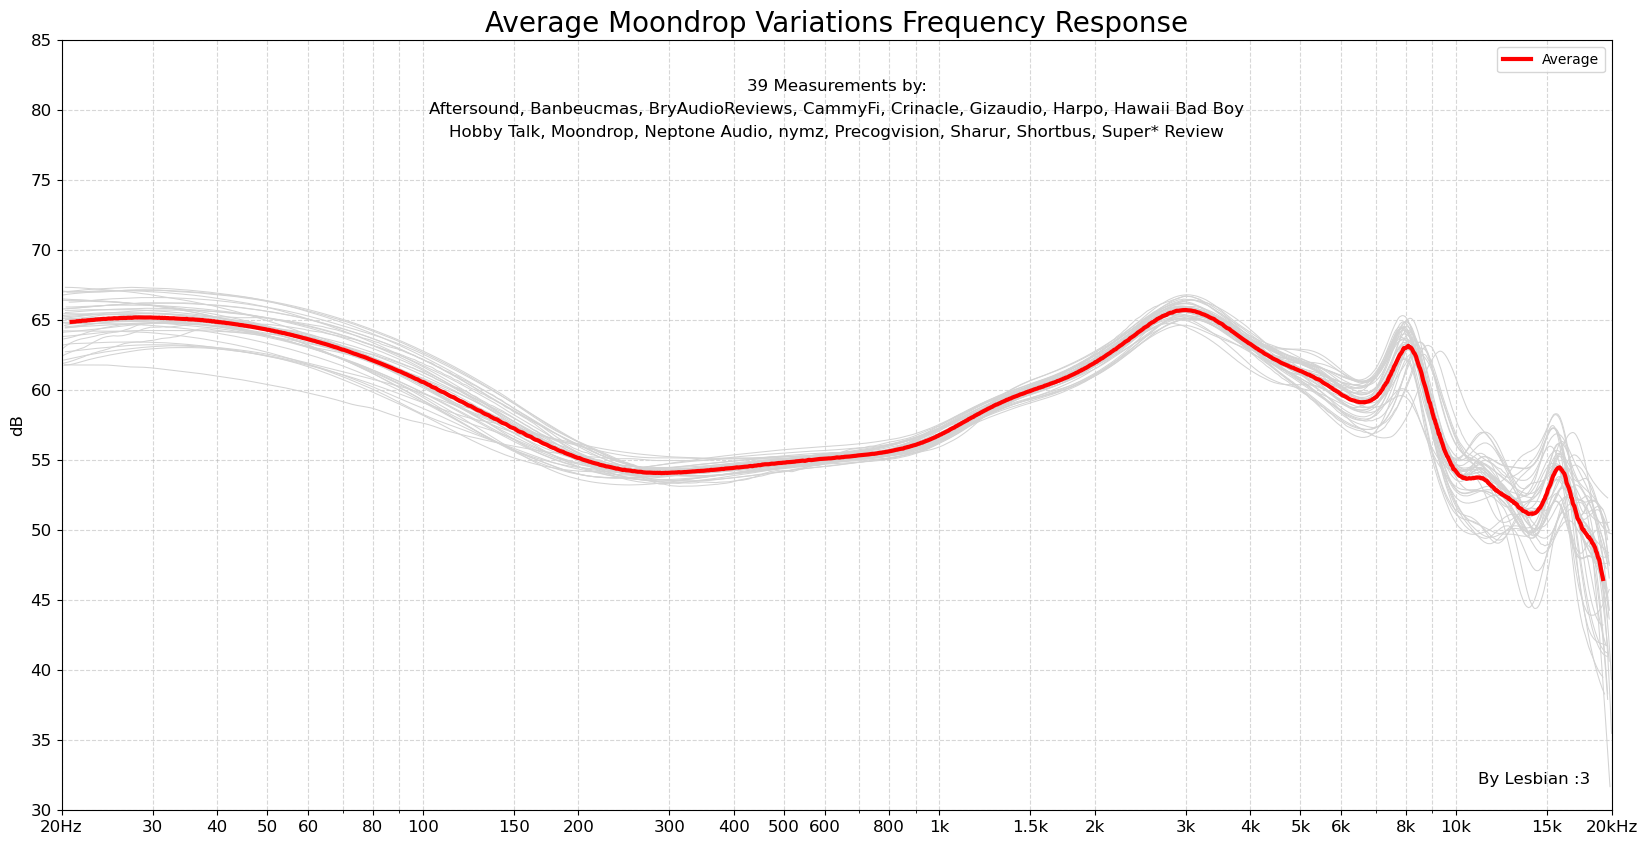

In [6]:
# Plot the data using the calculated average and original data
plot_data(x_values, average, data, 'Average Moondrop Variations Frequency Response', 'red')

### Weighted-Average

In [7]:
# All Measurement Sources
sources = [
    'aftersound', 'banbeucmas', 'bryaudioreviews', 'cammyfi', 'crinacle',
    'gizaudio', 'harpo', 'hawaiibadboy', 'hobbytalk', 'misc', 'moondrop',
    'neptoneaudio', 'nymz', 'precog', 'sharur', 'shortbus', 'super'
]

# Initialize source_file_paths dictionary with empty lists for each source
source_file_paths = {source: [] for source in sources}

# Iterate over the file paths and categorize them
for file_path in file_paths:
    # Extract the source name from the file path
    source_name = file_path.split('/')[2].split('_')[0].lower()
    
    # If the source name is in the list of sources, append the file path to the corresponding list
    if source_name in sources:
        source_file_paths[source_name].append(file_path)


In [8]:
# Print the measurements in the precog group for testing
#rint(source_file_paths['precog'])

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

def create_average_from_csv_files(file_paths, output_path='output/'):

    def read_and_interpolate(file_path, x_values):
        df = pd.read_csv(file_path)
        min_x = df['X'].min()
        max_x = df['X'].max()
        x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
        f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
        y_values = np.empty_like(x_values)
        y_values[:] = np.nan
        y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
        return y_values

    def find_mean_in_range(data, x_min, x_max):
        indices = (x_values >= x_min) & (x_values <= x_max)
        return np.mean(data[indices])

    x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

    data = [read_and_interpolate(file_path, x_values) for file_path in file_paths]

    alignment_freq_range = (200, 10000)  # frequency range for alignment

    mean_values = [find_mean_in_range(data[i], *alignment_freq_range) for i in range(len(data))]

    target_mean = np.mean(mean_values)

    for i in range(len(data)):
        shift = target_mean - mean_values[i]
        data[i] += shift

    average = np.mean(data, axis=0)

    average_df = pd.DataFrame({'X': x_values, 'Y': average})
    average_df = average_df.dropna(subset=['Y'])  # Remove rows where Y is NaN
    average_df.to_csv(output_path, index=False)

for source in sources:
    create_average_from_csv_files(source_file_paths[source], output_path=f'output/source/average_{source}.csv')


In [10]:
import os

# Define the directory path
directory = r'F:\GitHub\KU-1\Variations\output\source'

# Create an empty list to store the file paths
weighted_file_paths = []

# Loop through all the files in the directory and its subdirectories
for root, dirs, files in os.walk(directory):
    for file in files:
        # Check if the file is a .csv file
        if file.endswith('.csv'):
            # If it is, append its path (relative to the directory) to the csv_files list
            weighted_file_paths.append(os.path.join(root[len(directory)+1:], file))

# Add the directory path to each file path in the list
weighted_file_paths = [os.path.join('output', 'Source', file).replace('\\', '/') for file in weighted_file_paths]


In [11]:
# Calculate the average using the list of file directories
weighted_x_values, weighted_average, weighted_data = calculate_average(weighted_file_paths, 'output/weighted_community_avg_variations.csv')

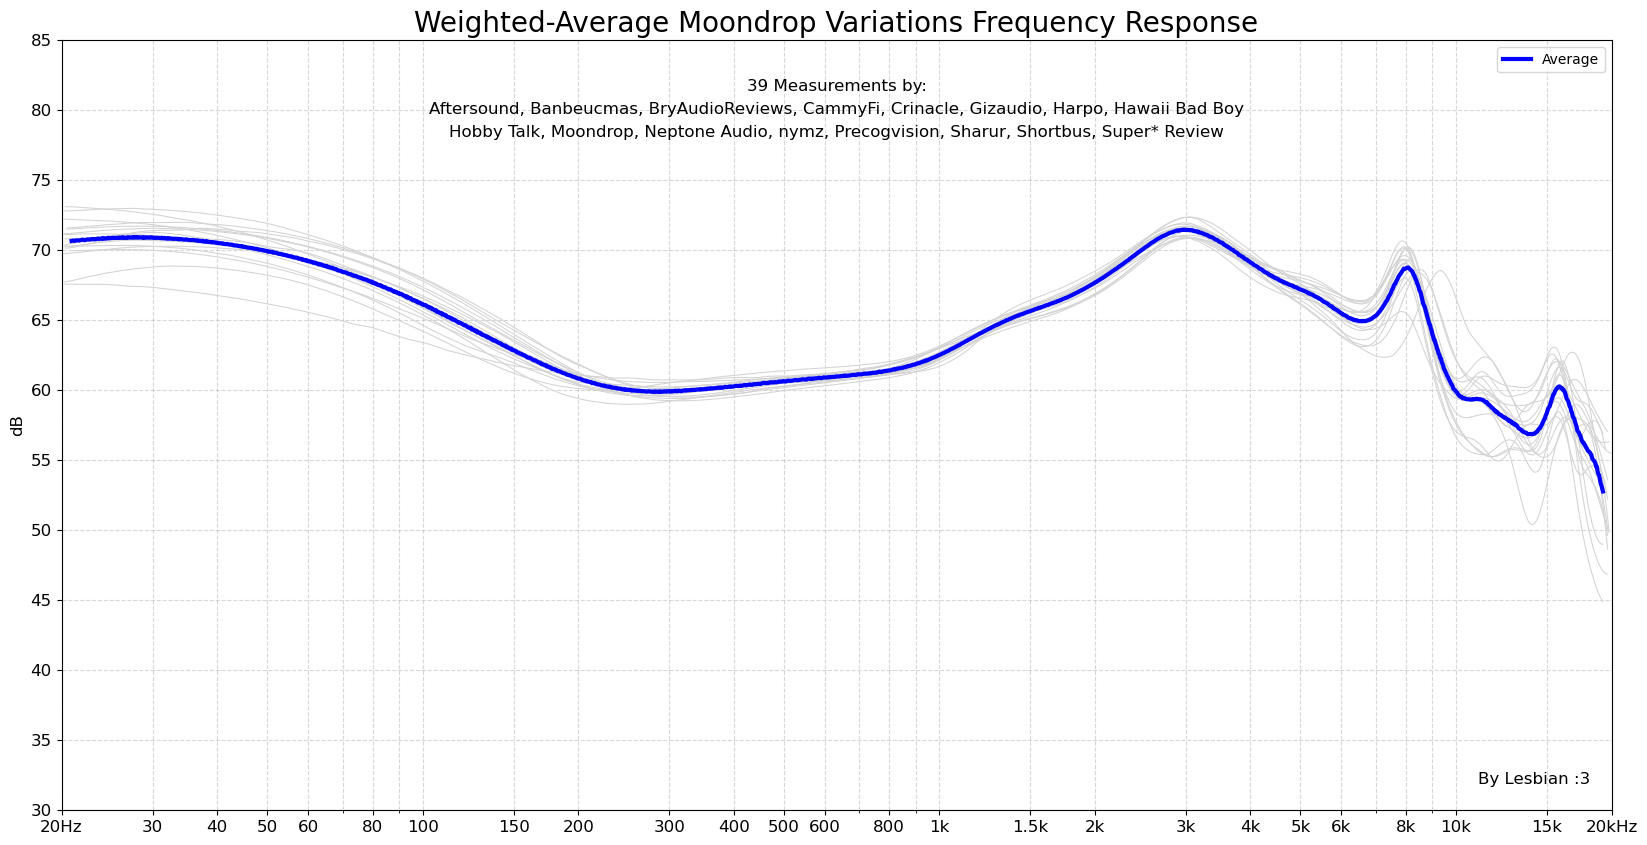

In [12]:
# Plot the data using the calculated average and original data
plot_data(weighted_x_values, weighted_average, weighted_data, 'Weighted-Average Moondrop Variations Frequency Response', 'blue')

### Preference %

In [13]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

def read_and_interpolate(file_path, x_values):
    df = pd.read_csv(file_path)
    min_x = df['X'].min()
    max_x = df['X'].max()
    x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
    f = interp1d(df['X'], pd.to_numeric(df['Y'], errors='coerce'), kind='linear', fill_value='extrapolate')
    y_values = np.empty_like(x_values)
    y_values[:] = np.nan
    y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
    return y_values

def find_mean_in_range(data, x_min, x_max):
    indices = (x_values >= x_min) & (x_values <= x_max)
    return np.mean(data[indices])

def target_adherence(input_csv, target_csv):

    x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

    input_data = read_and_interpolate(input_csv, x_values)
    target_data = read_and_interpolate(target_csv, x_values)

    alignment_freq_range = (200, 10000)  # frequency range for alignment

    input_mean = find_mean_in_range(input_data, *alignment_freq_range)
    target_mean = find_mean_in_range(target_data, *alignment_freq_range)

    shift = target_mean - input_mean
    input_data += shift

    differences = np.abs(target_data - input_data)
    
    if np.any(np.isfinite(differences)):
        mean_difference = np.nanmean(differences)
    else:
        mean_difference = 0  # or np.nan if you prefer

    y_range = np.nanmax(target_data) - np.nanmin(target_data)

    adherence = 100 * (1 - mean_difference / y_range)

    return adherence

In [14]:
def plot_preference(input_csv, target_csv, adherence_percentage, colors):
    x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

    input_data = read_and_interpolate(input_csv, x_values)
    target_data = read_and_interpolate(target_csv, x_values)

    alignment_freq_range = (200, 10000)  # frequency range for alignment
    input_mean = find_mean_in_range(input_data, *alignment_freq_range)
    target_mean = find_mean_in_range(target_data, *alignment_freq_range)

    shift = target_mean - input_mean
    input_data += shift

    plt.figure(figsize=(20, 10))
    
    plt.ylim(30, 85)
    plt.xlim(20, 20000)

    # Plot input data (colored line)
    plt.plot(x_values, input_data, color=colors, linewidth=2, label='Input')

    # Plot target data (dotted line)
    plt.plot(x_values, target_data, color='gray', linestyle='--', linewidth=2, label='Target')

    # Color the areas where the input plot deviates from the target plot
    plt.fill_between(x_values, input_data, target_data, where=(input_data > target_data), facecolor='pink', alpha=0.5)
    plt.fill_between(x_values, input_data, target_data, where=(input_data < target_data), facecolor='pink', alpha=0.5)

    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('dB')
    plt.title(f'Preference Plot - Adherence: {adherence_percentage:.2f}%')
    plt.legend()

    # Customize X-axis
    x_ticks = np.array([
        20, 30, 40, 50, 60, 80, 100, 150,
        200, 300, 400, 500, 600, 800,
        1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000,
        10000, 15000, 20000
    ])
    labels = [
        f'{int(x)}Hz' if x == 20
        else f'{int(x)}' if x < 1000
        else f'{x/1000:.1f}k' if x == 1500
        else f'{x//1000:.0f}k' if x != 20000
        else '20kHz' for x in x_ticks
    ]
    plt.xticks(x_ticks, labels=labels, fontsize=12)

    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.show()

Vari Adherence: 95.60%
Xenns Top Adherence: 92.65%


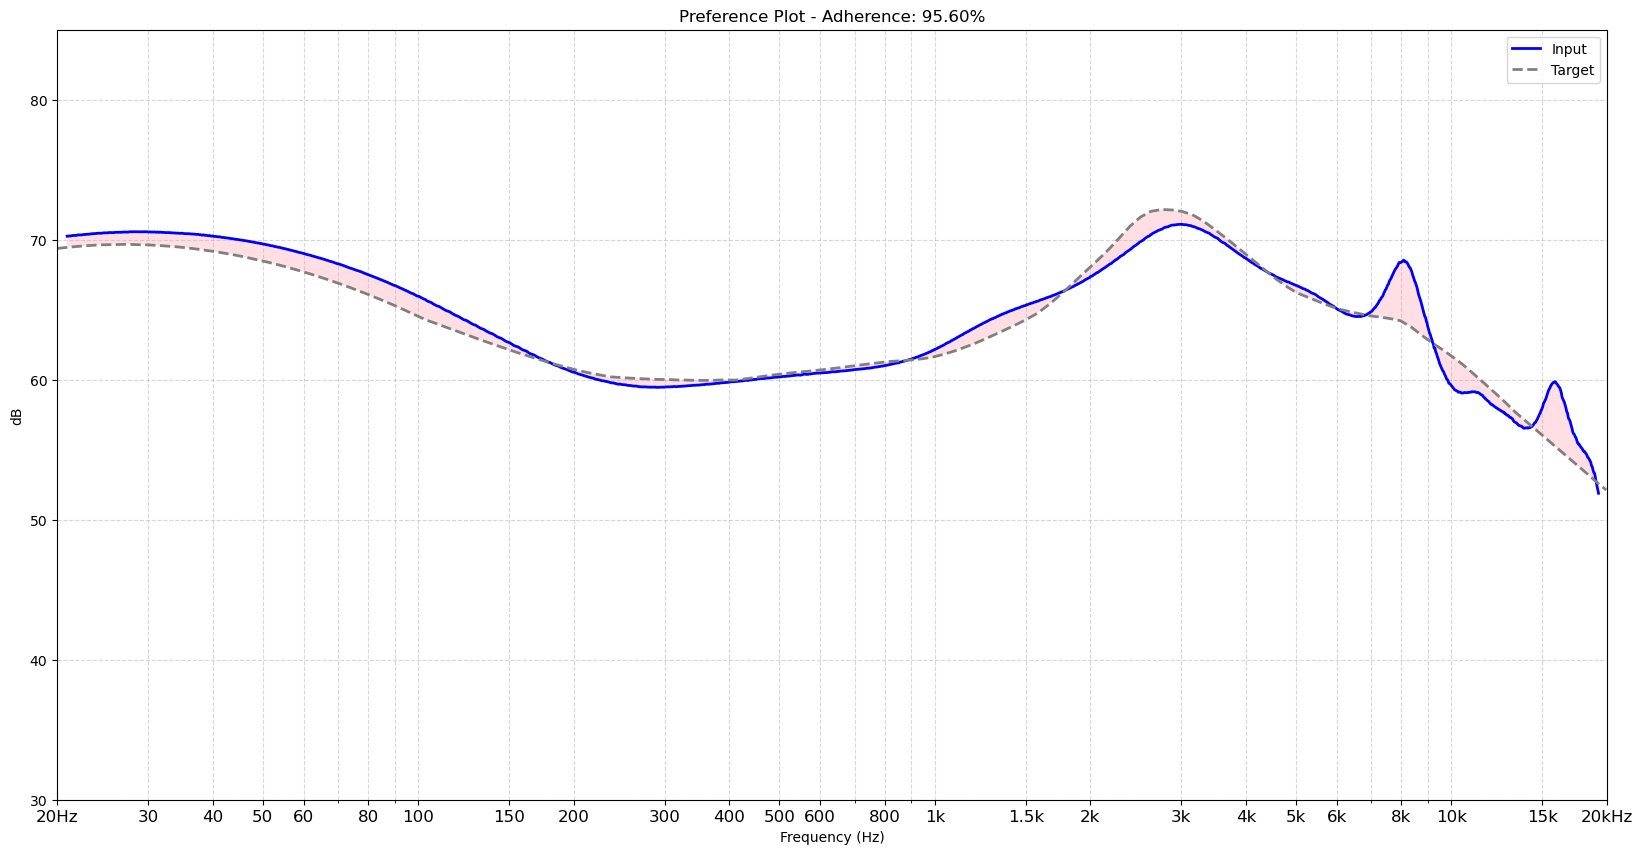

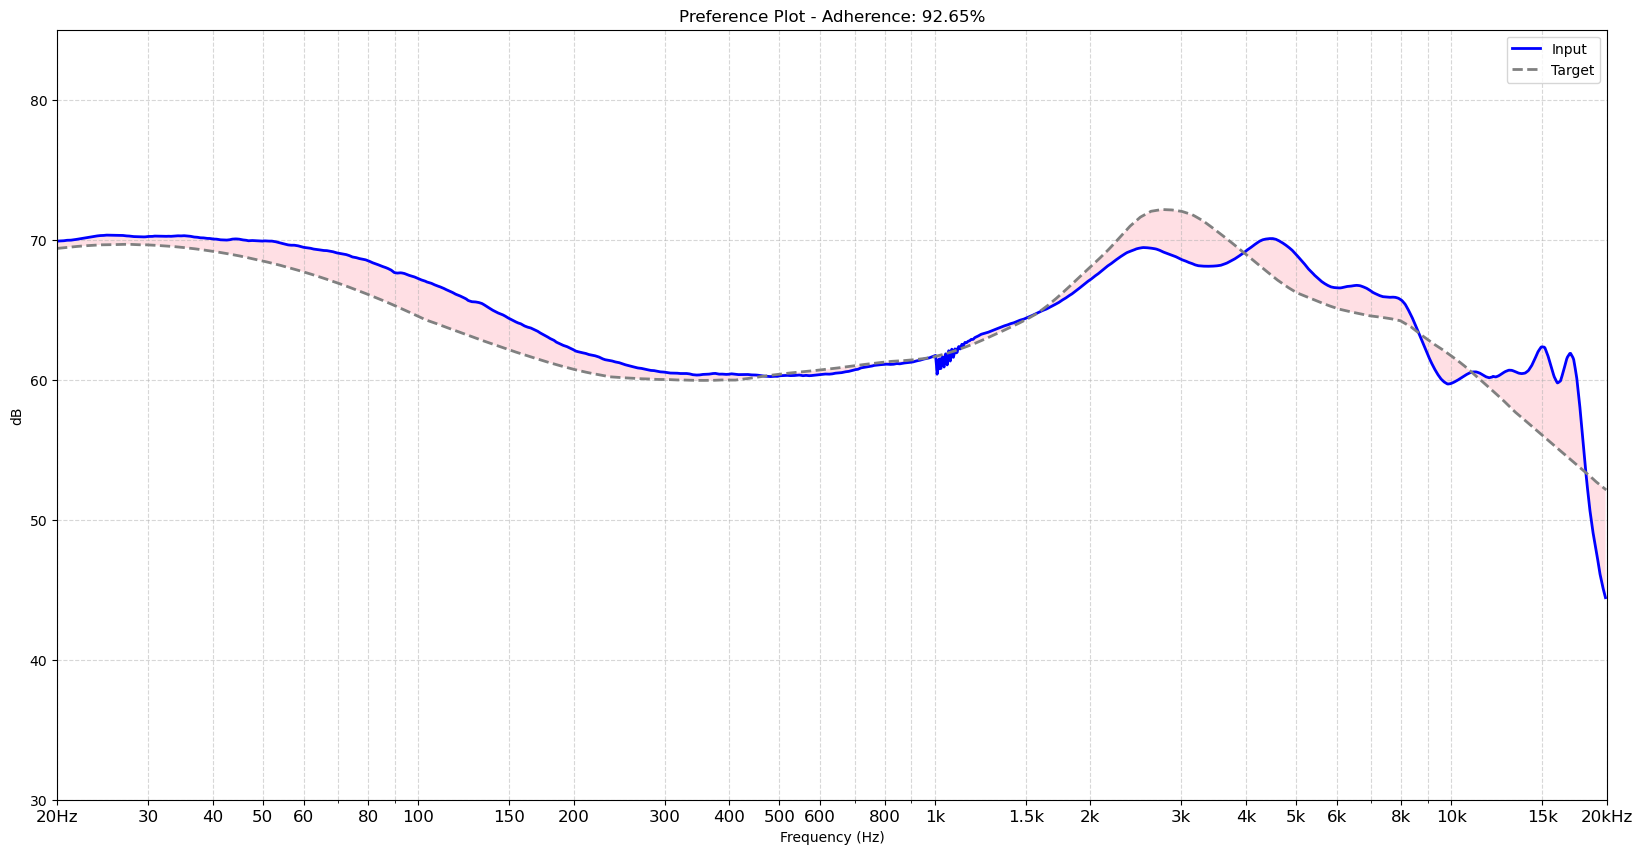

In [15]:
vari_csv = 'output/community_avg_variations.csv'
xennsTop_csv = 'output/community_avg_xenns_top.csv'
target_csv = 'Objectively Neutral IE Target.csv'
vari_adherence_percentage = target_adherence(vari_csv, target_csv)
xennsTop_adherence_percentage = target_adherence(xennsTop_csv, target_csv)

print(f"Vari Adherence: {vari_adherence_percentage:.2f}%")
print(f"Xenns Top Adherence: {target_adherence(xennsTop_csv, target_csv):.2f}%")


# Call the plot_preference function to create the plot
plot_preference(vari_csv, target_csv, vari_adherence_percentage, 'blue')

plot_preference(xennsTop_csv, target_csv, xennsTop_adherence_percentage, 'blue')

In [24]:
import os

# List of reviewers
reviewers = [
    'achoreviews',
    'aftersound',
    'animagus',
    'arn',
    'bedrock',
    'bryaudioreviews',
    'cammyfi',
    'soundjedi',
    'eplv',
    'timmyv',
    'harpo',
    'hbb',
    'cqtek',
    'hobbytalk',
    'ianfann',
    'iemworld',
    'jacstone',
    'kr0mka',
    'kurin',
    'melatonin',
    'nymz', 
    'pw',
    'recode',
    'rg',
    'shortbus',
    'suporsalad',
    'tgx78',
    'vortexreviews',
    'vsg',
    'wdym',
    'akros',
    'data_mrs'
]

# Gather all file names
all_files = []

for reviewer in reviewers:
    reviewer_path = f'output/csv/{reviewer}'
    
    if os.path.exists(reviewer_path):
        files = os.listdir(reviewer_path)
        all_files.extend([(reviewer, file) for file in files])

In [34]:
import pandas as pd

# create an empty list to store the adherence data
data = []

for iem in all_files:
    # calculate the adherence percentage
    adherence = target_adherence(f'output/csv/{iem[0]}/{iem[1]}', 'Objectively Neutral IE Target.csv')
    
    # print the file directory and adherence percentage
    #print(f'{iem} Adherence: {adherence}')
    
    # append the file directory and adherence percentage to the data list
    data.append({'File Directory': f'output/csv/{iem[0]}/{iem[1]}', 'Adherence %': adherence})
    
# create a Pandas DataFrame from the data list
df = pd.DataFrame(data)


In [35]:
df

,File Directory,Adherence %
0,output/csv/achoreviews/7Hz Dioko L.csv,90.698541
1,output/csv/achoreviews/7Hz Eternal L.csv,87.234573
2,output/csv/achoreviews/7Hz Legato L.csv,81.885583
3,output/csv/achoreviews/7Hz Timeless L.csv,91.039780
4,output/csv/achoreviews/7Hz Zero L.csv,94.212215
...,...,...
9877,output/csv/data_mrs/Xenns Mangird Tea L.csv,92.339586
9878,output/csv/data_mrs/Yanyin Mahina L.csv,90.370581
9879,output/csv/data_mrs/Yanyin Mahina R.csv,89.627539
9880,output/csv/data_mrs/Yinfu MD51 L.csv,83.055861


In [36]:
sorted_df = df.sort_values(by='Adherence %', ascending=False)

In [39]:
pd.set_option('display.max_rows', None)

In [40]:
sorted_df

,File Directory,Adherence %
8770,output/csv/vsg/Ugreen HiTune T3 L.csv,100.000000
5258,output/csv/kurin/Objectively Neutral IE Target...,100.000000
7597,output/csv/shortbus/Not 02 L.csv,100.000000
5034,output/csv/jacstone/Sharur Target.csv,100.000000
9192,output/csv/data_mrs/HBB Comp Target.csv,100.000000
2967,output/csv/hbb/HBB 1 R.csv,100.000000
9212,output/csv/data_mrs/IEF Comp Target.csv,100.000000
7596,output/csv/shortbus/Mystery IEM L.csv,100.000000
5257,output/csv/kurin/Normative Target.csv,97.049948
5152,output/csv/kr0mka/kr0mka Target.csv,96.932293
